In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io import loadmat

# Clustering

Clustering is unsupervised process which divides the population or data points into a number of groups or clusters such that data points in same cluster are more similar to other points in the same clusters than points in other clusters.

## Distance / Dissimilarity
Data points are classified based on the distance between two element. The distance between two points can be defined as follows:
$$
\mathbf{d(x, y) = [\sum_{i=1}^n|x_i - y_i|^q]^{1/q}} \\
\text{where }x \text{ and } y \text{ are two vectors of length }n.
$$
- When q = 2, we have Euclidean distance
- When q = 1, we have Manhattan distance

## Clustering Methods

### Hierarchical Methods
This category performs a stepwise classification, and the adjective "hierarchical" means that the choices done at each step are never reconsidered. Starting from a dissimilarity (distance table) of each point with respect to all the other ones, we have two different kinds of method:
- AGNES (AGglomerative NESting): a bottoms-up approach where every data point is considered as a singleton cluster. And then the similar clusters are continously merged until the stop criterion is satisfied.
<img src="https://www.datasciencecentral.com/wp-content/uploads/2021/10/image-23-3.jpg" border=0 style="width: 400px;">
- DIANA (DIvisive ANAlysis): a top-down approach where all data points are initially assigned to a single cluster. And then split the largest cluster into two least similar ones until the previous defined criterion is satisfied.

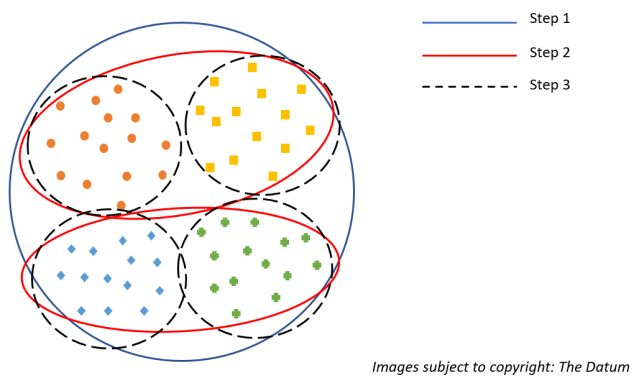

### Optimization Methods
This class of clustering methods derives from the minimization of a target function:
$$
\mathbf{\Phi_{\alpha,p}(\omega_{ic}, \underline{m}_c) = \sum_c\sum_i\omega_{ic}^\alpha|\underline{x}_i-\underline{m}_c|_{\ell^p}} \\
where \\
\alpha = \text{power for the weights. 1 implies a hard classification methods while 2 implies a soft classification} \\
\omega_{ic} = \text{weight / cluster membership} \\
\underline{m}_c = \text{cluster representative element} \\
\underline{x}_i = \text{element to be classified} \\
{\ell^p} = \text{kind of distance}
$$

Different values of $\alpha$ and $p$ characterize different optimization methods:

| $\alpha$ | $p$ | Methods |
| --- | --- | --- |
| 1 | 1 | PAM (partitioning around medoids) |
| 1 | 2 | K-means (partitioning around the mean) |
| 2 | 2 | FUZZY |

## Cluster Validity

### Silhouette Index
Silhouette value is a measure of how similar an object is to its own cluster compared to other clusters. It ranges from -1 to 1, where a high value means the point is well mathed to its cluster and poorly matched to neighboring clusters.

Silhouette analysis could also help us to assess parameters like number of clusters visually.

$$
a(i)={\frac {1}{|C_{I}|-1}}\sum _{j\in C_{I},i\neq j}d(i,j) \quad i \in C_I\\
b(i)=\min _{J\neq I}{\frac {1}{|C_{J}|}}\sum _{j\in C_{J}}d(i,j) \quad i \in C_I\\
s(i)={\frac {b(i)-a(i)}{\max\{a(i),b(i)\}}}, \quad if \quad |C_{I}|>1
$$

### Adjusted Rand Index (ARI) (TODO)
The adjusted Rand index is a measure of the similarity between two data clusterings, which is adjusted for the chance grouping of elements.

# QGIS and QGIS plugins

QGIS is a free and open-source Geographic Information System. The functionality of QGIS can be extended using plugins and plugins can be written in Python, which is easier to develop and simpler for distribution than C++ plugins. During the development, PyQt is used, which is a Python binding of the cross-platform GUI toolkit Qt.

<table><tr>
<td><img src="https://www.qgis.org/en/_static/logo.png" border=0 style="width: 100px;"></td>
<td><img src="https://download.logo.wine/logo/PyQt/PyQt-Logo.wine.png" style="width: 200px;" border=0></td>
</tr></table>

# EO Clustering Plugins
In this plugin, we implement DIANA and Fuzzy algorithms based on a previous Matlab implementation.
- These algorithms are implemented as a python package and invoked by the plugin.
- The implementation of the algorithms are tested against other implementation and show positive results.
- The clustering results are compared to understand their pros and cons.
- The plugin is also tested in the QGIS.

## Testing

### Accuracy
Both algorithms are run and compared with the results generated by the Matlab implementation on 1-dimension and 2-dimension dataset.

FUZZY is also compared with [SckiKit](https://scikit-fuzzy.readthedocs.io/en/latest/), which is a fuzzy logic toolbox for SciPy.

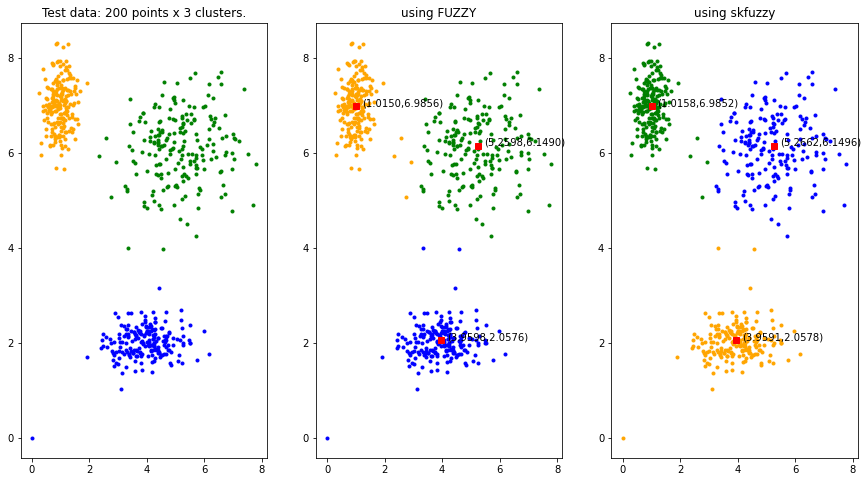

In [2]:
from test_classification import compare
compare.compare_fuzzy_skfuzzy()

### Performance
The performance of the algorithms are tested on the datasets with different population. All datasets are generated by "SIMUDATA" function in Matlab script, with the same number of clusters (3), same number of bands (2), same means and covariance of clusters, and equal probability of clusters.

The result shows that he running time of DIANA increases sharply with the increase of the number of samples, while the running time of FUZZY is basically unchanged.

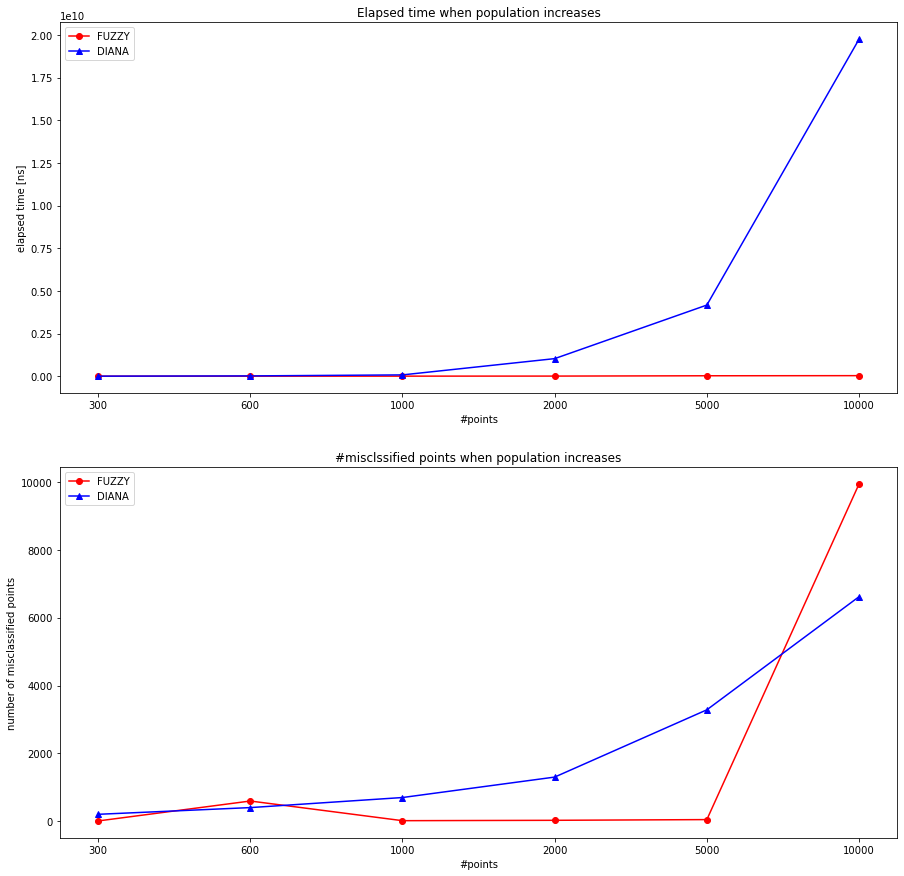

In [3]:
# show result (test_classification/performance.json)
import json
with open(r"test_classification/performance.json") as f:
    perjs = json.load(f)

et = {'fuzzy': [], 'diana': []}
mn = {'fuzzy': [], 'diana': []}
tots = [300, 600, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
xticks = []
for tot in tots:
    key = "data_{}.mat".format(tot)
    if key not in perjs: break
    et['fuzzy'].append(perjs[key]['fuzzy']["elapse_time"])
    et['diana'].append(perjs[key]['diana']["elapse_time"])
    mn['fuzzy'].append(perjs[key]['fuzzy']["misclassified_number"])
    mn['diana'].append(perjs[key]['diana']["misclassified_number"])
    xticks.append(tot)

#plot
fig, ax = plt.subplots(2,1, figsize = (15,15))
X = range(len(xticks))
ax[0].plot(X, et['fuzzy'], 'ro-', label="FUZZY")
ax[1].plot(X, mn['fuzzy'], 'ro-', label="FUZZY")
ax[0].plot(X, et['diana'], 'b^-', label="DIANA")
ax[1].plot(X, mn['diana'], 'b^-', label="DIANA")
ax[0].legend()
ax[1].legend()
ax[0].set_title("Elapsed time when population increases")
ax[1].set_title("#misclssified points when population increases")
ax[0].set_xlabel("#points")
ax[1].set_xlabel("#points")
ax[0].set_ylabel("elapsed time [ns]")
ax[1].set_ylabel("number of misclassified points")
ax[0].set_xticks(X)
ax[0].set_xticklabels(xticks)
ax[1].set_xticks(X)
_ = ax[1].set_xticklabels(xticks)

## Comparison between different methods (TODO)


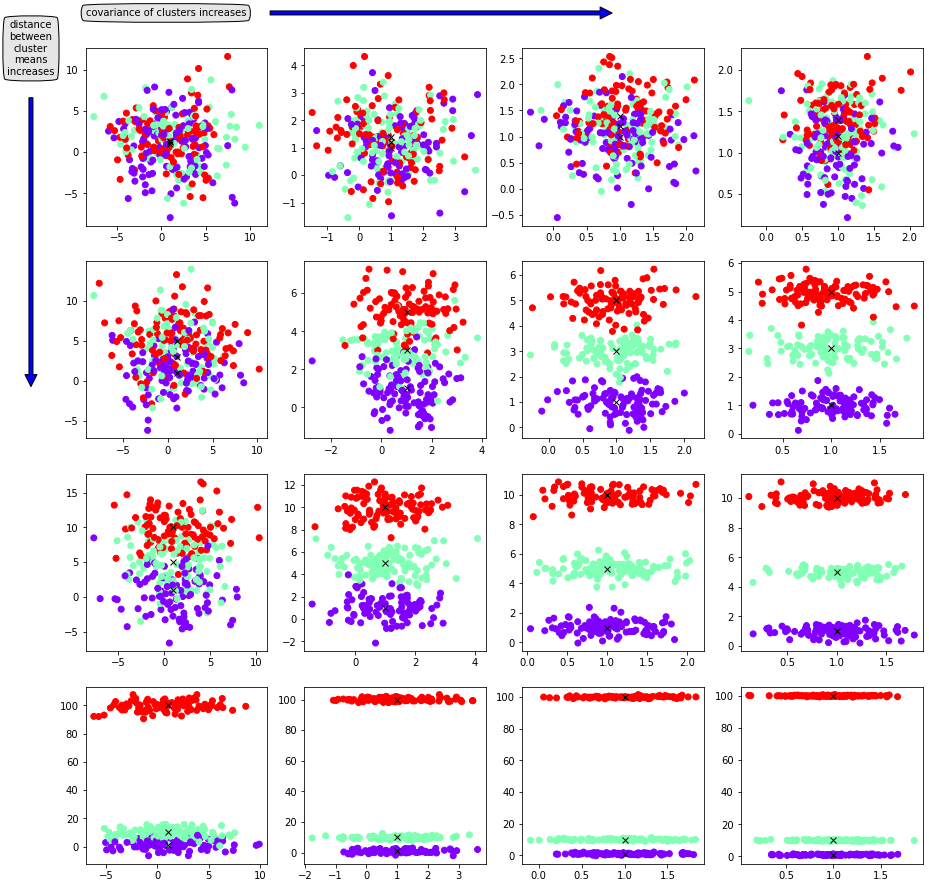

In [4]:
# load data for comparison and plot (different variance and distance of cluster mean)
dfolder = r'test_classification/data/compare/'

fig, ax = plt.subplots(4,4, figsize = (15,15))

for i in range(1, 5): # same i, same distance mean
    for j in range(1, 5): # same j, same covariance
        dname = dfolder + 'data_{}_{}.mat'.format(i,j)
        mat = loadmat(dname)
        if i != mat['i'] or j != mat['j']:
            print("Wrong MAT!!", i, mat['i'], j, mat['j'])
            break
        dataset = mat['mix']
        label = mat['label']
        ms = mat['mu_cl']
        ax[i-1,j-1].scatter(dataset[:,0], dataset[:,1], c=label, cmap='rainbow')
        # center
        ax[i-1,j-1].plot(ms[:,0], ms[:,1], 'kx')
        #ax[i-1,j-1].set_title('({},{})'.format(i,j))
        
ax[0,0].annotate('covariance of clusters increases', xy=(3, 1.2), xycoords='axes fraction', xytext=(0, 1.2),
                 va='center', bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),
                arrowprops=dict(facecolor='blue', shrink=0.05)
                 #arrowprops=dict(arrowstyle="simple")
                )
ax[0,0].annotate('distance\nbetween\ncluster\nmeans\nincreases', xy=(-0.3, -1), xycoords='axes fraction', xytext=(-0.3, 1),
                 va='center', ha='center',
                 bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),
                       arrowprops=dict(facecolor='blue', shrink=0.05)
                )
plt.show()

In [5]:
# show result (test_classification/comopare.json)
import json
with open(r"test_classification/compare.json") as f:
    compjs = json.load(f)

In [6]:
l = [[[0.1, 0.0], [0.0, 0.1]], [[0.1, 0.0], [0.0, 0.1]]]
import pprint
pp = pprint.PrettyPrinter(width=18, compact=True)
r = pp.pformat(l)

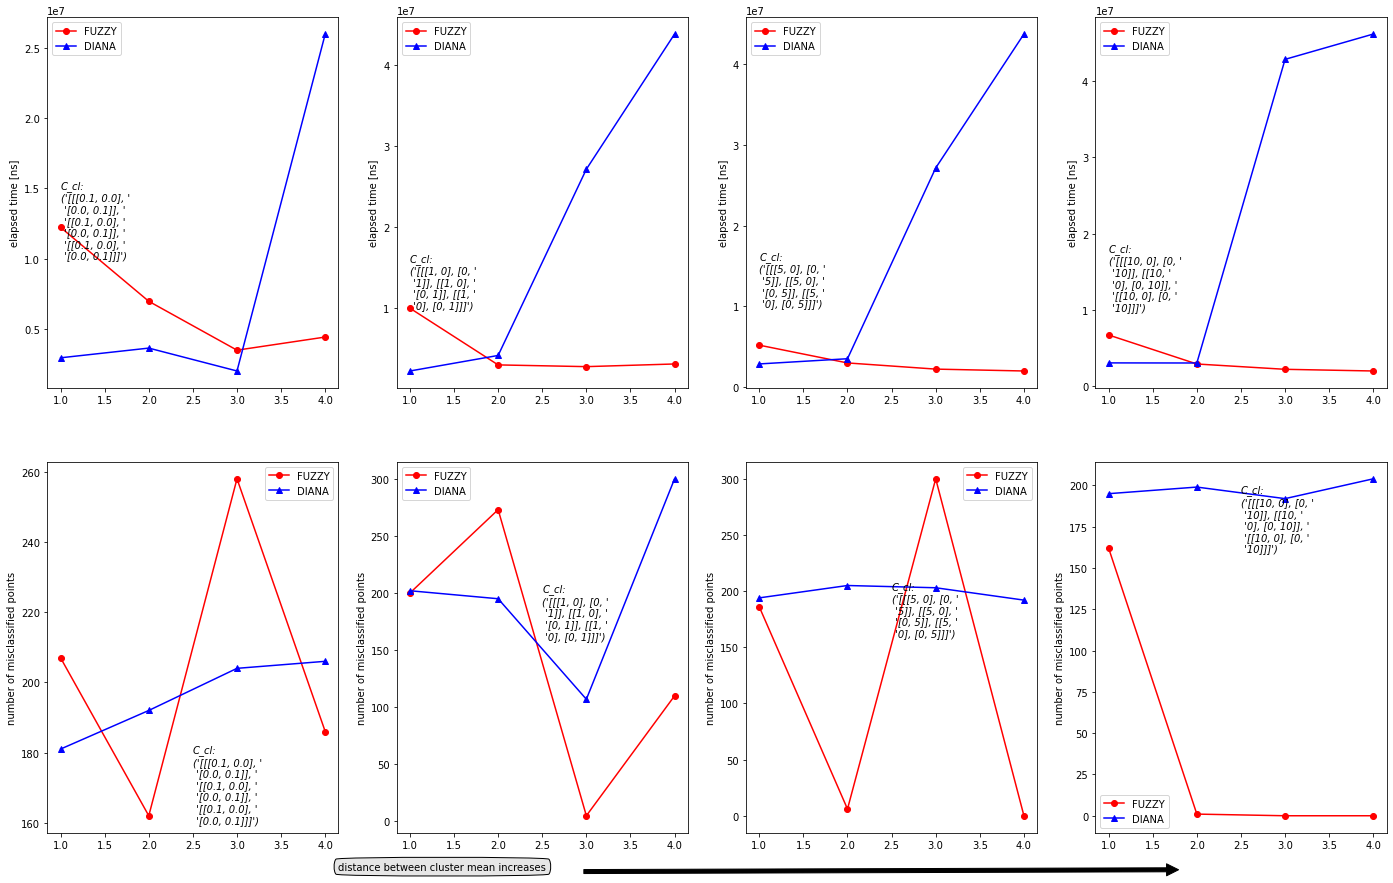

In [14]:
# compare between different distance between cluster mean
fig, ax = plt.subplots(2,4, figsize = (24,15))

for j in range(1, 5): # same j, same covariance
    et = {'fuzzy': [], 'diana': []}
    mn = {'fuzzy': [], 'diana': []}
    title = ""
    for i in range(1, 5): # same i, same distance mean
        key = 'data_{}_{}.mat'.format(i,j)
        et['fuzzy'].append(compjs[key]['fuzzy']["elapse_time"])
        et['diana'].append(compjs[key]['diana']["elapse_time"])
        mn['fuzzy'].append(compjs[key]['fuzzy']["misclassified_number"])
        mn['diana'].append(compjs[key]['diana']["misclassified_number"])
        #print(i, j, compjs[key]["C_cl"])
        title = pp.pformat(json.dumps(compjs[key]["C_cl"]))
        
    ax[0,j-1].plot(range(1, 5), et['fuzzy'], 'ro-', label="FUZZY")
    ax[1,j-1].plot(range(1, 5), mn['fuzzy'], 'ro-', label="FUZZY")
    ax[0,j-1].plot(range(1, 5), et['diana'], 'b^-', label="DIANA")
    ax[1,j-1].plot(range(1, 5), mn['diana'], 'b^-', label="DIANA")
    ax[0,j-1].legend()
    ax[1,j-1].legend()
    ax[0,j-1].text(1, 1e7, "C_cl:\n"+title, style='italic')
    ax[1,j-1].text(2.5, 160, "C_cl:\n"+title, style='italic')
    ax[0,j-1].set_ylabel("elapsed time [ns]")
    ax[1,j-1].set_ylabel("number of misclassified points")
    
ax[1,0].annotate('distance between cluster mean increases', xy=(4, -0.1), xycoords='axes fraction', xytext=(1, -0.1),
                 bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),
                       arrowprops=dict(facecolor='black', shrink=0.05)),
plt.show()

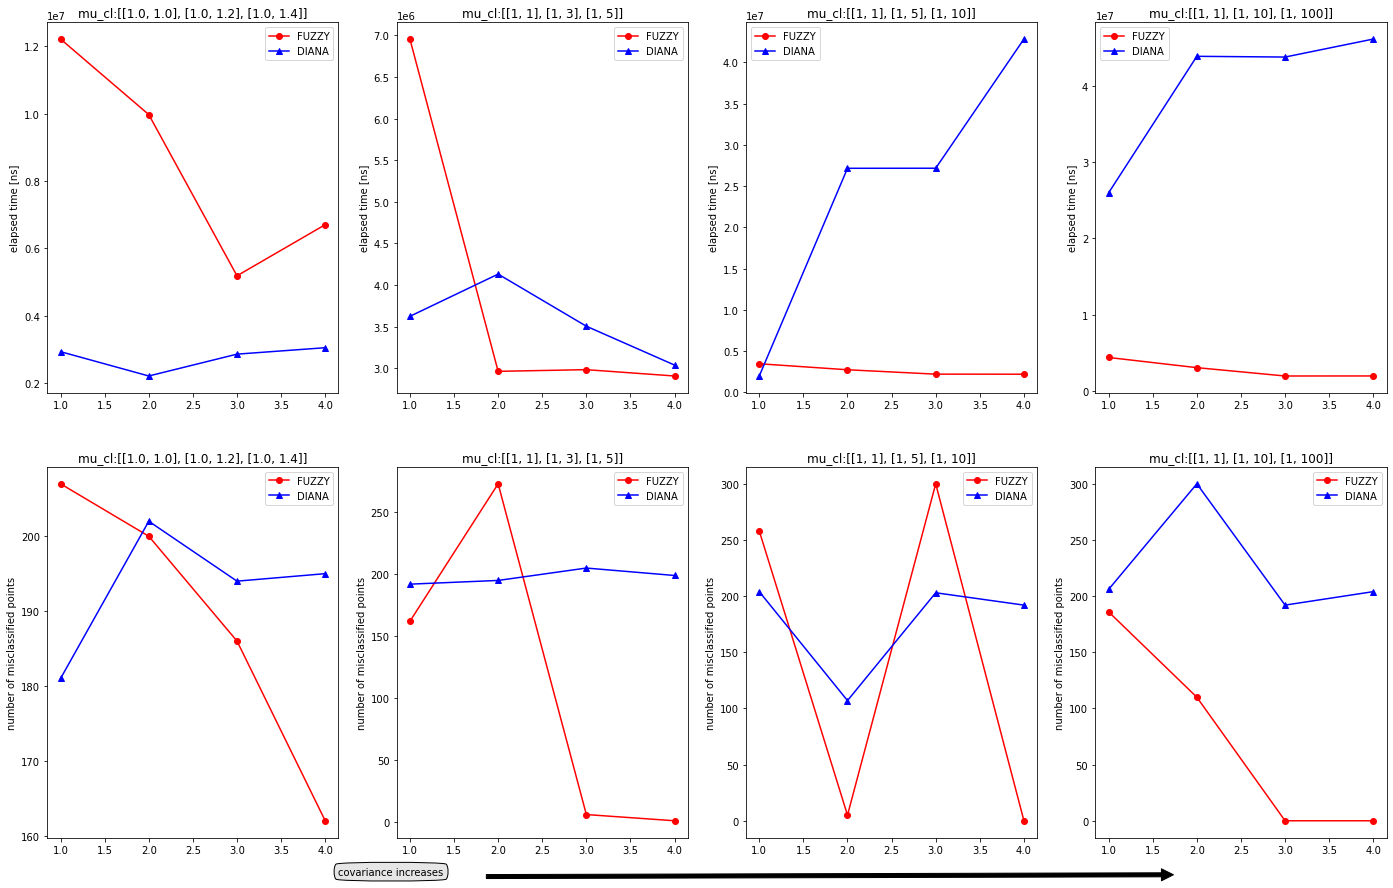

In [8]:
# compare between different covariance
fig, ax = plt.subplots(2,4, figsize = (24,15))

for i in range(1, 5): # same i, same distance mean
    et = {'fuzzy': [], 'diana': []}
    mn = {'fuzzy': [], 'diana': []}
    title = ""
    for j in range(1, 5): # same j, same covariance
        key = 'data_{}_{}.mat'.format(i,j)
        et['fuzzy'].append(compjs[key]['fuzzy']["elapse_time"])
        et['diana'].append(compjs[key]['diana']["elapse_time"])
        mn['fuzzy'].append(compjs[key]['fuzzy']["misclassified_number"])
        mn['diana'].append(compjs[key]['diana']["misclassified_number"])
        title = json.dumps(compjs[key]["mu_cl"])

        
    ax[0,i-1].plot(range(1, 5), et['fuzzy'], 'ro-', label="FUZZY")
    ax[1,i-1].plot(range(1, 5), mn['fuzzy'], 'ro-', label="FUZZY")
    ax[0,i-1].plot(range(1, 5), et['diana'], 'b^-', label="DIANA")
    ax[1,i-1].plot(range(1, 5), mn['diana'], 'b^-', label="DIANA")
    ax[0,i-1].legend()
    ax[1,i-1].legend()
    ax[0,i-1].set_title("mu_cl:"+title)
    ax[1,i-1].set_title("mu_cl:"+title)
    ax[0,i-1].set_ylabel("elapsed time [ns]")
    ax[1,i-1].set_ylabel("number of misclassified points")

ax[1,0].annotate('covariance increases', xy=(4, -0.1), xycoords='axes fraction', xytext=(1, -0.1),
                 bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),
                       arrowprops=dict(facecolor='black', shrink=0.05)),
                      
plt.show()

## Run in QGIS
After the classification algorithms are tested, we now can integrate them into the QGIS plugin. In the plugin:
1. 
![](images/load.jpg)

2.
![](images/process.jpg)

3. 
<table><tr>
<td><img src="./images/result_origin.jpg" style="width: 200px;" border=0></td>
<td><img src="./images/result.jpg" border=0 style="width: 300px;"></td>
<td><img src="./images/result_f.jpg" style="width: 200px;" border=0></td>
<td><img src="./images/result_d.jpg" style="width: 200px;" border=0></td>
</tr></table>

# Summary
- The Matlab implementation for DIANA store the labels for every iteration, which is memory consuming when applied to large dataset. Therefore, in python implementation, only the store the previous and the current labels.
- DIANA method is easy to understand and implement. But itrealy provides the best solution. Besides, it is not pratical for Earth Observation since the raster file always contain large data such that the runtime is unacceptable. 

# Reference
- Lectures of Earth Observation in Politecnico
- [PyQGIS Developer Cookbook](https://docs.qgis.org/3.22/en/docs/pyqgis_developer_cookbook/)
- [WIKI: Silhouette_(clustering)](https://en.wikipedia.org/wiki/Silhouette_(clustering))
- [WIKI: Adjusted Rand index](https://en.wikipedia.org/wiki/Rand_index#Adjusted_Rand_index)

# Code Organization
```sh
eo_classification/
├── Makefile
├── README.html
├── README.txt
├── Support
│   └── QGIS
│       └── QGIS3
│           └── profiles
│               └── default
│                   └── python
│                       └── plugins
│                           └── python
│                               └── plugins
│                                   └── eo_classification
│                                       ├── __init__.py
│                                       ├── eo_classification.py
│                                       └── eo_classification_dialog.py
├── __init__.py
├── __pycache__
│   ├── __init__.cpython-38.pyc
│   ├── eo_classification.cpython-38.pyc
│   ├── eo_classification.cpython-39.pyc
│   ├── eo_classification_dialog.cpython-38.pyc
│   └── resources.cpython-38.pyc
├── classification
│   ├── __init__.py
│   ├── __pycache__
│   ├── distance.py
│   ├── hierarchical.py
│   ├── optimization.py
│   ├── plots.py
│   └── statistics.py
├── eo_classification.py
├── eo_classification_dialog.py
├── eo_classification_dialog_base.ui
├── help
│   ├── Makefile
│   ├── build
│   │   ├── doctrees
│   │   │   ├── environment.pickle
│   │   │   └── index.doctree
│   │   └── html
│   │       ├── _sources
│   │       │   └── index.rst.txt
│   │       ├── _static
│   │       │   ├── basic.css
│   │       │   ├── classic.css
│   │       │   ├── default.css
│   │       │   ├── doctools.js
│   │       │   ├── documentation_options.js
│   │       │   ├── file.png
│   │       │   ├── jquery-3.5.1.js
│   │       │   ├── jquery.js
│   │       │   ├── language_data.js
│   │       │   ├── minus.png
│   │       │   ├── plus.png
│   │       │   ├── pygments.css
│   │       │   ├── searchtools.js
│   │       │   ├── sidebar.js
│   │       │   ├── underscore-1.3.1.js
│   │       │   └── underscore.js
│   │       ├── genindex.html
│   │       ├── index.html
│   │       ├── objects.inv
│   │       ├── search.html
│   │       └── searchindex.js
│   ├── make.bat
│   └── source
│       ├── _static
│       ├── _templates
│       ├── conf.py
│       └── index.rst
├── i18n
│   └── af.ts
├── icon.png
├── metadata.txt
├── pb_tool.cfg
├── plugin_upload.py
├── presentation.ipynb
├── pylintrc
├── resources.py
├── resources.qrc
├── scripts
│   ├── compile-strings.sh
│   ├── run-env-linux.sh
│   └── update-strings.sh
├── test
│   ├── __init__.py
│   ├── qgis_interface.py
│   ├── tenbytenraster.asc
│   ├── tenbytenraster.asc.aux.xml
│   ├── tenbytenraster.keywords
│   ├── tenbytenraster.lic
│   ├── tenbytenraster.prj
│   ├── tenbytenraster.qml
│   ├── test_eo_classification_dialog.py
│   ├── test_init.py
│   ├── test_qgis_environment.py
│   ├── test_resources.py
│   ├── test_translations.py
│   └── utilities.py
└── test_classification # folder, which contain the data and scripts used for method test
    ├── __init__.py
    ├── __pycache__
    ├── compare.py
    ├── data
    │   ├── compare # folder, which contains data used for method comparison
    │   ├── data_2_3_601.txt # data used for accuracy test, generated by simudata.py
    │   ├── performance # folder, which contains data used for method performance test
    │   └── simudata.py
    ├── pylib.py
    ├── test_hierarchical.py # accuracy test for hierarchical method (DIANA)
    └── test_optimization.py # accuracy test for optimization method (FUZZY)
```